In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
img_folder = '../images/'

In [6]:
img_2b827 = mpimg.imread(img_folder + '2b827.png')
img_2cg58 = mpimg.imread(img_folder + '2cg58.png')

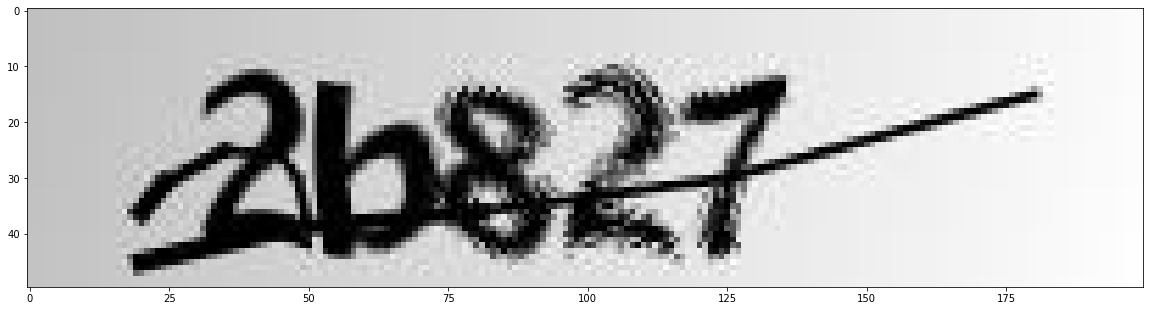

In [7]:
plt.figure(figsize=(20, 16))
plt.imshow(img_2b827)
plt.show()

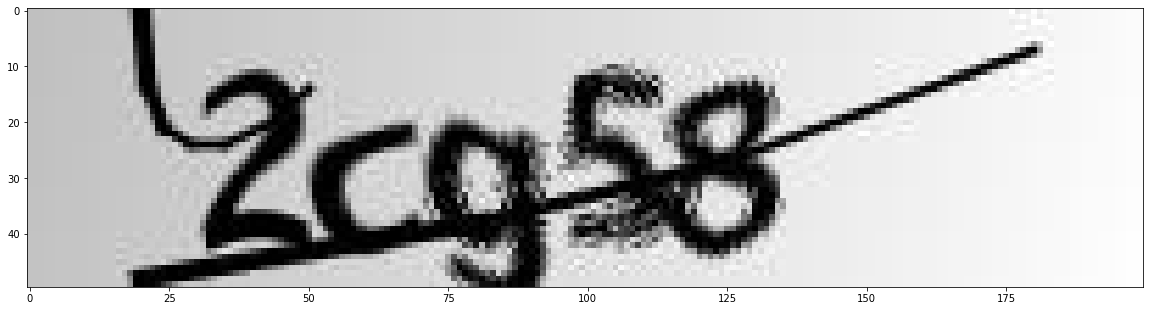

In [8]:
plt.figure(figsize=(20, 16))
plt.imshow(img_2cg58)
plt.show()

In [9]:
img_2cg58.shape

(50, 200, 4)

In [10]:
img_2b827.shape

(50, 200, 4)

In [11]:
def compute_perf_metrics(predictions, ground_truth):
    if predictions.shape == ground_truth.shape:
        return np.sum(predictions == ground_truth) / (predictions.shape[0] * predictions.shape[1])
    else:
        raise Exception('Error: The size of the arrays does not match')

In [12]:
# Encoding

vocabulary = {'2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y'}
char_to_num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18}

In [13]:
# Encoding Function

def encode_single_sample(img_path, label, crop=False):
    # Read image file and returns a tensor with dtype=string
    img = tf.io.read_file(img_path)
    # Decode and convert to grayscale (this conversion does not cause any information lost and reduces the size of the tensor)
    # This decode function returns a tensor with dtype=uint8
    img = tf.io.decode_png(img, channels=1)
    # Scales and returns a tensor with dtype=float32
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    # Crop and resize to the original size : 
    # top-left corner = offset_height, offset_width in image = 0, 25 
    # lower-right corner is at offset_height + target_height, offset_width + target_width = 50, 150
    if (crop):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=25, target_height=50, target_width=125)
        img = tf.image.resize(img, size=[50,200], method='bilinear', preserve_aspect_ratio=False, antialias=False, name=None)
    # Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2]) # REVISIT NEEDED
    # Converts the string label into an array with 5 integers. E.g. '6n6gg' is converted into [6,16,6,14,14]
    label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label

In [14]:
# Creating a test and validation data splitting function
def create_train_and_validation_datasets(crop=False):
    # Loop on all the files to create X whose shape is (1040, 50, 200, 1) and y whose shape is (1040, 5)
    X, y = [], []
    for _, _, files in os.walk(img_folder):
        for f in files:
            # To start, let's ignore the jpg images
            label = f.split('.')[0]
            extension = f.split('.')[1]
            if extension == 'png':
                img, label = encode_single_sample(img_folder + f, label, crop)
                X.append(img)
                y.append(label)
                
    X = np.array(X)
    y = np.array(y)
    
    # Splitting our data into test and val datasets
    X_train, X_val, y_train, y_val = train_test_split(X.reshape(1040, 10000), y, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_val = X_train.reshape(936,200,50,1), X_val.reshape(104,200,50,1)
    return X_train, X_val, y_train, y_val

In [21]:
# Building a Model

def buid_model():
    # Input Layer
    input_img = layers.Input(shape=(200, 50, 1), name='image', dtype='float32')
    
    # First Convolution Block
    x = layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer="he_normal", padding="same", name='Conv-1')(input_img)
    x = layers.MaxPooling2D((2, 2), name='MaxPool-1')(x)
    
    # Second Convolution Block
    x = layers.Conv2D(64, (2, 2), activation='relu', kernel_initializer="he_normal", padding="same", name='Conv-2')(x)
    x = layers.MaxPooling2D((2, 2), name='MaxPool-2')(x)
    
     # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (50,12,64) 
    # Reshape to "split" the volume in 5 time-steps
    x  = layers.Reshape(target_shape=(5, 7680), name='reshape')(x)
    
    # FC layers
    x = layers.Dense(256, activation='relu', name='dense1')(x)
    x = layers.Dense(64, activation='relu', name='dense2')(x)
    
    # Output Layer
    output = layers.Dense(19, activation='softmax', name='ouput')(x)
    
    # Define Model
    model = keras.models.Model(inputs=input_img, outputs=output, name='ocr_classifier')
    
    # Compiling the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
    
    return model

model = buid_model()
model.summary()
    

Model: "ocr_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv-1 (Conv2D)              (None, 200, 50, 32)       160       
_________________________________________________________________
MaxPool-1 (MaxPooling2D)     (None, 100, 25, 32)       0         
_________________________________________________________________
Conv-2 (Conv2D)              (None, 100, 25, 64)       8256      
_________________________________________________________________
MaxPool-2 (MaxPooling2D)     (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 7680)           0         
_________________________________________________________________
dense1 (Dense)               (None, 5, 256)         

### Train the model

In [22]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
30/30 [==============================] - 10s 245ms/step - loss: 3.1305 - accuracy: 0.0863 - val_loss: 2.8648 - val_accuracy: 0.0981
Epoch 2/30
30/30 [==============================] - 6s 207ms/step - loss: 2.7131 - accuracy: 0.1459 - val_loss: 2.5578 - val_accuracy: 0.2192
Epoch 3/30
30/30 [==============================] - 7s 232ms/step - loss: 2.3503 - accuracy: 0.2733 - val_loss: 2.1566 - val_accuracy: 0.3808
Epoch 4/30
30/30 [==============================] - 6s 206ms/step - loss: 1.7763 - accuracy: 0.4558 - val_loss: 1.3991 - val_accuracy: 0.5442
Epoch 5/30
30/30 [==============================] - 6s 205ms/step - loss: 1.0785 - accuracy: 0.6885 - val_loss: 1.0552 - val_accuracy: 0.6769
Epoch 6/30
30/30 [==============================] - 7s 227ms/step - loss: 0.7563 - accuracy: 0.7846 - val_loss: 0.7906 - val_accuracy: 0.7808
Epoch 7/30
30/30 [==============================] - 6s 208ms/step - loss: 0.5850 - accuracy: 0.8342 - val_loss: 0.6482 - val_accuracy: 0.8173
Epoch

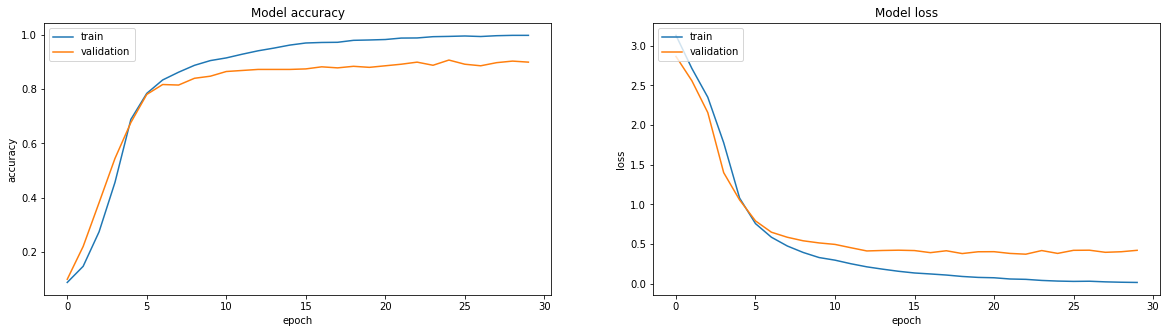

In [23]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()